Możliwe urządzenie: cuda


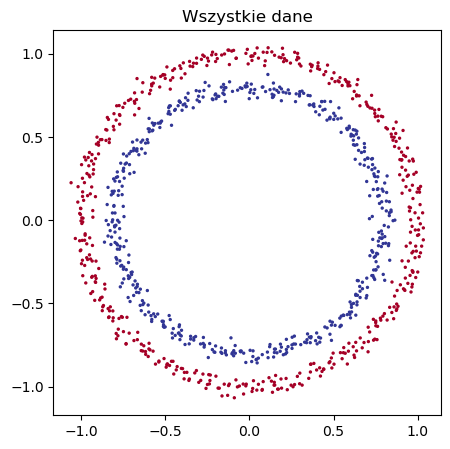

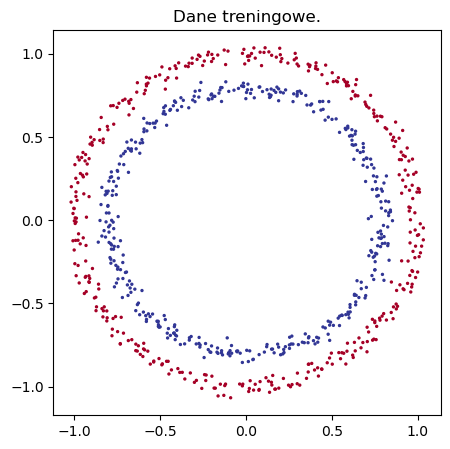

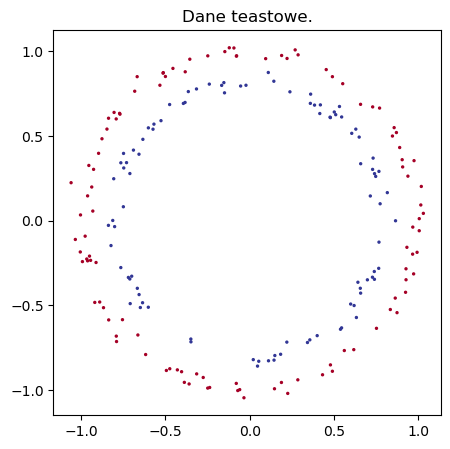

Model działa na urządzeniu: cuda:0
Model po zmianie działa na urządzeniu: cuda:0


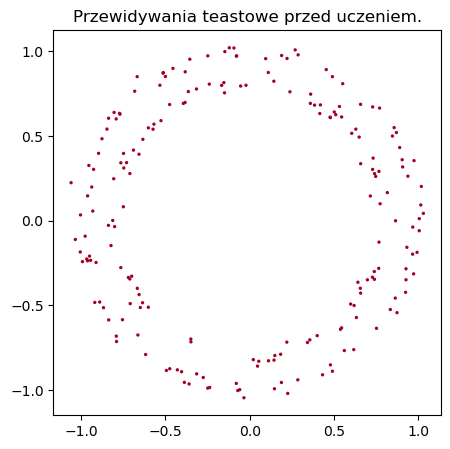

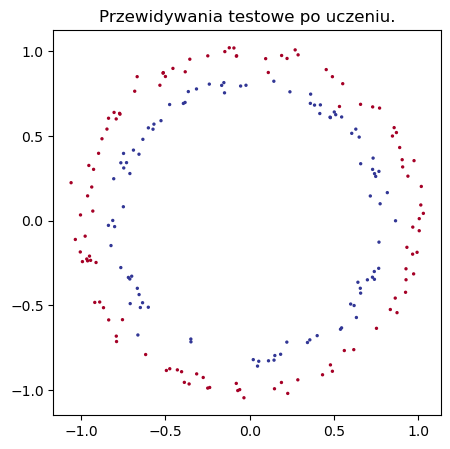

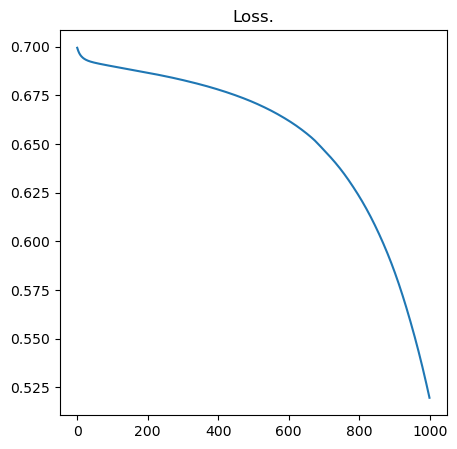

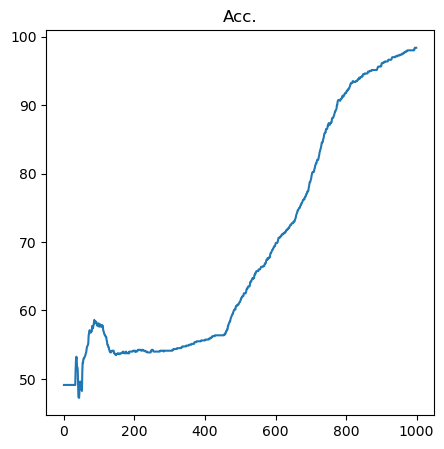

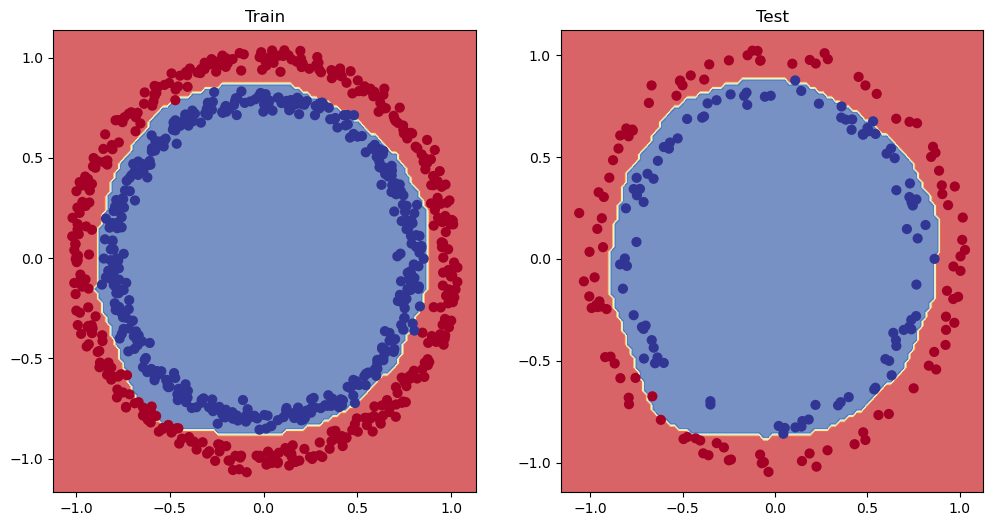

In [6]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

# generowanie danych, dwa koła z punktów jedno w drugim X[(x,y)pozycja], y[0 lub 1], dane wymieszane
from sklearn.datasets import make_circles 
X, y = make_circles(1000, noise=0.03, random_state=42)

plt.figure(figsize=(5, 5))
plt.title('Wszystkie dane')
plt.scatter(X[:,0], X[:,1], s=2, c=y, cmap=plt.cm.RdYlBu);
plt.show()

# zamiana na tensory i ustalwienie na cuda, oraz rozłożenie na trening i test
X = torch.tensor(X).type(torch.float32).to(device)
y = torch.tensor(y).type(torch.float32).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# wizualizacja danych treningowych i testowych
plt.figure(figsize=(5, 5))
plt.title('Dane treningowe.')
plt.scatter(X_train[:,0].cpu().numpy(), X_train[:,1].cpu().numpy(), s=2, c=y_train.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.show()

plt.figure(figsize=(5, 5))
plt.title('Dane teastowe.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=2, c=y_test.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.show()

# budowanie modelu
class ModelNN(nn.Module):
    def __init__(self):
        super().__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.layer_1 = nn.Linear(in_features=2, out_features=16) 
        self.layer_2 = nn.Linear(in_features=16, out_features=16) 
        self.layer_3 = nn.Linear(in_features=16, out_features=1) 
        self.relu = nn.ReLU() # dodanie funkcji aktywacyjnej nie liniowej, łamie linie na mniejsze
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = ModelNN().to(device)
# ---------------------------------------------------------------------------------------------
# sprawdzenie na jakim urządzeniu działa model
print(f'Model działa na urządzeniu: {next(model.parameters()).device}')

# przewidywania przed uczeniem
with torch.inference_mode(): 
    y_preds = model(X_test)
# y_preds, y_preds.shape
plt.figure(figsize=(5, 5))
plt.title('Przewidywania teastowe przed uczeniem.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=2, c=np.round(y_preds.cpu().numpy()), cmap=plt.cm.RdYlBu)
plt.show()

# Ustawienia loss i optymalizator
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) 

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# Trening i test
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
epoch_count = []
loss_values = []
acc_values = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss wymaga jako wejście raw preds, i przeliczonych po sigmoid 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_count.append(epoch)
    loss_values.append(loss)
    acc_values.append(acc)    
    
model.eval()
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

plt.figure(figsize=(5, 5))
plt.title('Przewidywania testowe po uczeniu.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=2, c=np.round(test_pred.cpu().numpy()), cmap=plt.cm.RdYlBu)
plt.show()

plt.figure(figsize=(5, 5))
plt.title('Loss.')
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label='Train loss')
plt.show()

plt.figure(figsize=(5, 5))
plt.title('Acc.')
plt.plot(epoch_count, np.array(torch.tensor(acc_values).cpu().numpy()), label='Train acc')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)